# Loading in the Active Learning functions

In [1]:
import numpy as np
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd, 'CustomFunctions'))
from ActiveLearning import *
os.chdir(cwd)

# Load in the data

In [2]:
# Use the same data as question 2.
filepath = "hw4_ex2_data.csv"

data = []
with open(filepath) as f:
    header = f.readline().strip().split(',')
    print('Header Categories:', end = " ")
    for i, category in enumerate(header): print(f"col {i}: {category}    ", end = "")
    for line in f:
        line = line.strip().split(',')
        line = [float(x) for x in line]
        data.append(line)
data = np.array(data)
x = data[:, :2]
y = data[:, 2]
print(f'\nThe shape of the data is: {data.shape}\nFeature shape: {x.shape}\nLabel shape: {y.shape}')
print(f'Number of unique classes {len(np.unique(y))}')

Header Categories: col 0: x1    col 1: x2    col 2: y    col 3: cost    col 4: ignore this!    
The shape of the data is: (200, 5)
Feature shape: (200, 2)
Label shape: (200,)
Number of unique classes 3


## Uncertainty Sampling with batch size = 3

In [3]:
import multiprocessing as mp
from sklearn.base import clone
from sklearn.svm import SVC

num_simulations = 10 # Number of simulations
batch_size = 3
results = []
with mp.Pool(mp.cpu_count()-1) as p:
    clf = SVC()
    results = []
    for i in range(num_simulations):
        p.apply_async(SimulateAL,
                    kwds= {'x':x, 'y':y, 'method':'US', 'seed':i*2024,
                    'clf':clone(clf), 'stratify_data':y,
                    'init_frac':5/x.shape[0], 'end_frac':0.5,
                    'logging_func':TestLog, 'batch_size':batch_size},
                    callback=lambda res: results.append(res))
    p.close()
    p.join()
    
    # args = [(x, y, None,  'US', i*2024, clone(clf), [], y, None, 5/x.shape[0], 0.5, None, TestLog, True, batch_size) for i in range(num_simulations)]
    # starmap_results = p.starmap_async(SimulateAL, args)
    # starmap_results.wait()
    # results = starmap_results.get()


In [4]:
save = True
filepath = 'results/US_accuracy.npy'
if save:
    np.save(filepath, np.array(results).squeeze())

# Diversity Sampling

In [5]:
import multiprocessing as mp
from sklearn.base import clone
from sklearn.svm import SVC
from functools import partial

num_simulations = 10 # Number of simulations
batch_size = 3
with mp.Pool(mp.cpu_count()-1) as p:
    clf = SVC()
    results = []
    for i in range(num_simulations):
        p.apply_async(SimulateAL,
                    kwds= {'x':x, 'y':y, 'method':'DVS', 'seed':i*2024,
                    'clf':clone(clf), 'stratify_data':y,
                    'init_frac':5/x.shape[0], 'end_frac':0.5,
                    'logging_func':TestLog, 'batch_size':batch_size},
                    callback=lambda res: results.append(res))
    p.close()
    p.join()

    # args = [(x, y, 'DVS', i*2024, clone(clf), [], y, None, 5/x.shape[0], 0.5, TestLog, True, batch_size) for i in range(num_simulations)]
    # starmap_results = p.starmap_async(SimulateAL, args)
    # starmap_results.wait()
    # results = starmap_results.get()


In [6]:
save = True
filepath = 'results/DVS_accuracy.npy'
if save:
    np.save(filepath, np.array(results).squeeze())

# Plot Results

In [7]:
import matplotlib.pyplot as plt
def PlotData(filepath, label, n, batch_size, fig, ax):
    data = np.load(filepath)
    end_frac = 0.5

    x = np.linspace(5, 5+batch_size*int(np.ceil((int(n*end_frac)-5)/batch_size)), 1+int(np.ceil((int(n*end_frac)-5)/batch_size)))
    y = np.mean(data, axis = 0)
    y_std = np.std(data, axis = 0)   

    handle, = ax.plot(x,y, label = label)
    color = handle.get_color()
    ax.errorbar(x, y, y_std, color = color, linestyle = '', capsize=5, alpha = 0.2)


Text(0.5, 0, 'Number of samples in labeled set')

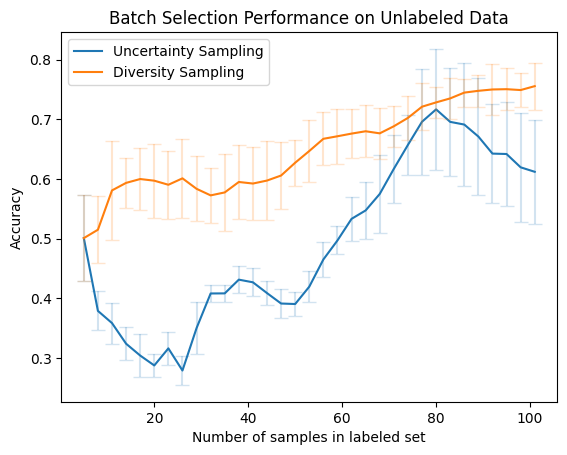

In [8]:
filepaths = ['results/US_accuracy.npy', 'results/DVS_accuracy.npy']
labels = ['Uncertainty Sampling', 'Diversity Sampling']
batch_size = 3
fig, ax = plt.subplots()

for i in range(len(labels)):
    PlotData(filepaths[i], labels[i], x.shape[0], batch_size, fig, ax)
ax.legend()
ax.set_title('Batch Selection Performance on Unlabeled Data')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of samples in labeled set')